In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re,json,nltk

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer

stopwords_list = '/content/drive/MyDrive/DATAset/stopwords-bn.txt'

In [2]:
data = pd.read_csv('/content/drive/MyDrive/DATAset/Train.csv',encoding='UTF-8')

data.head(10)

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
5,"যেমন : পরীক্ষার রেজাল্টের সময় , বিভিন্ন ব্যানি...",0
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2
7,"সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই , চ...",1
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে ? গাল...,0
9,"তুমি রেপারই হও , ডাক্তার হওয়ার দরকার নাই তোমার",0


In [3]:
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Label =='1']),
      "\nTotal Negative Reviews:",len(data[data.Label=='2']),
      "\nTotal Neutral Reviews:",len(data[data.Label =='0']))

Total Reviews: 31414 
Total Positive Reviews: 10646 
Total Negative Reviews: 14298 
Total Neutral Reviews: 6357


In [4]:
# Data cleaning function
def process_comments(Comment): 
    Comment = re.sub('[^\u0980-\u09FF]',' ',str(Comment)) #removing unnecessary punctuation
    return Comment

In [5]:
def remove_bnDigit(Comment): 
    Comment = re.sub('[০-৯]',' ',str(Comment)) #removing unnecessary digit
    return Comment

In [6]:
data['Data'] = data['Data'].apply(remove_bnDigit)

In [7]:
# Apply the function into the dataframe
data['cleaned'] = data['Data'].apply(process_comments)  

# print some cleaned reviews from the dataset
sample_data = [10,100,25,854,966,1500,1589,1700,2000,2500,4000,4500]
for i in sample_data:
     print('Original:\n',data.Data[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment: ',data.Label[i],'\n')

Original:
 লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট  
Cleaned:
 লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট  
 Sentiment:  2 

Original:
 ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা , দিদি কে দেখতে পেলে ভালো লাগত  
Cleaned:
 ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা   দিদি কে দেখতে পেলে ভালো লাগত  
 Sentiment:  1 

Original:
 ভালো লাগল বিউটি বোডিং দেখে । আমি শুনেছি বাংলাদেশ এর সাধীনতা র ইতিহাস এর সাথে একাত্ত্ব এই বোডিং হাউস 
Cleaned:
 ভালো লাগল বিউটি বোডিং দেখে   আমি শুনেছি বাংলাদেশ এর সাধীনতা র ইতিহাস এর সাথে একাত্ত্ব এই বোডিং হাউস 
 Sentiment:  1 

Original:
 আল্লাহ কে ভয় করা উচিত । অাল্লাহ চাইলে এর চেয়েও ভয়াবহ ভাবে পৃথিবী ধ্বংস করতে পারেন । এটা নমুনা মাত্র  
Cleaned:
 আল্লাহ কে ভয় করা উচিত   অাল্লাহ চাইলে এর চেয়েও ভয়াবহ ভাবে পৃথিবী ধ্বংস করতে পারেন   এটা নমুনা মাত্র  
 Sentiment:  1 

Original:
 বাংলাদেশের কি গুন , শুধু নিউজিই হয় । এত খুন ধর্ষণ হয় একটারও তো ফাঁসি হয় না । বলতে লজ্জা লাগে আমাদের দেশটা হয়ে যাচ্ছে মেরুদন্ডহীন দেশ  
Cleaned:
 বাংলাদেশের কি গুন   শুধু নিউজিই হয়   এত খুন ধর্ষণ হয় এ

In [8]:
data.drop("Data",axis=1,inplace=True)

In [9]:
data.head(10)

,Label,cleaned
0,1,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...
1,2,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...
2,1,ভাই আপনার কথাই যাদু রয়েছে
3,1,উওরটা আমার অনেক ভাল লেগেছে
4,0,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...
5,0,যেমন পরীক্ষার রেজাল্টের সময় বিভিন্ন ব্যানি...
6,2,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...
7,1,সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই চ...
8,0,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে গাল...
9,0,তুমি রেপারই হও ডাক্তার হওয়ার দরকার নাই তোমার


In [10]:
first_column = data.pop('cleaned')

In [11]:
data.insert(0, 'cleaned', first_column)

In [12]:
data.head(10)

,cleaned,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0
5,যেমন পরীক্ষার রেজাল্টের সময় বিভিন্ন ব্যানি...,0
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2
7,সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই চ...,1
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে গাল...,0
9,তুমি রেপারই হও ডাক্তার হওয়ার দরকার নাই তোমার,0


In [13]:
data.rename(columns={"cleaned": "review"}, inplace=True)
data.head(5)

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0


In [14]:
len(data)

31414

In [15]:
data.drop(data.index[(data["Label"] == "conflict")],axis=0,inplace=True)
len(data)

31301

In [16]:
data.head(10)

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0
5,যেমন পরীক্ষার রেজাল্টের সময় বিভিন্ন ব্যানি...,0
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2
7,সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই চ...,1
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে গাল...,0
9,তুমি রেপারই হও ডাক্তার হওয়ার দরকার নাই তোমার,0


In [17]:
print(data.loc[data['Label'] == 'conflict'])

Empty DataFrame
Columns: [review, Label]
Index: []


In [18]:
data.drop_duplicates(subset="review", keep="first", inplace=True)
len(data)

29862

In [19]:
data.head()

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0


**31414 to 29886 (1528 rows removed)**
duplicate cleaned,
punctuation cleaned,
label cleaned

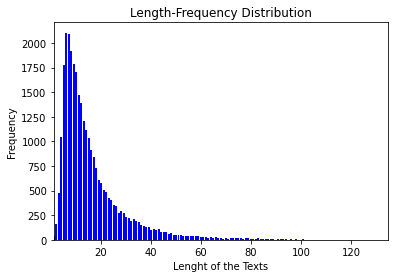

Maximum Length of a review: 118
Minimum Length of a review: 0
Average Length of a reviews: 16.0


In [20]:
# Calculate the Review of each of the Review
data['ReviewLength'] = data.review.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(data.ReviewLength)}")
print(f"Minimum Length of a review: {min(data.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(data.ReviewLength),0)}")

In [21]:
# Length of each Reveiws
data['length'] = data['review'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
data = data.loc[data.length>3]
data = data.loc[data.length<41]
data = data.reset_index(drop = True)


In [22]:
len(data)

27511

In [23]:
data.head(10)

,review,Label,ReviewLength,length
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1,22,22
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2,18,18
2,ভাই আপনার কথাই যাদু রয়েছে,1,5,5
3,উওরটা আমার অনেক ভাল লেগেছে,1,5,5
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0,12,12
5,যেমন পরীক্ষার রেজাল্টের সময় বিভিন্ন ব্যানি...,0,8,8
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2,30,30
7,সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই চ...,1,9,9
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে গাল...,0,8,8
9,তুমি রেপারই হও ডাক্তার হওয়ার দরকার নাই তোমার,0,8,8


In [24]:
data.isnull().sum()

review          0
Label           0
ReviewLength    0
length          0
dtype: int64

In [25]:

from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('bengali'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
data['review'] = data['review'].apply(remove_stopwords)

In [27]:
print(stop_words)

{'অর্থাত', 'অনেকে', 'জন', 'হত', 'এসে', 'মধ্যেই', 'কখনও', 'সহ', 'ধরা', 'থাকা', 'মাত্র', 'যান', 'এত', 'কয়েকটি', 'তা', 'পেয়ে', 'করিয়ে', 'মতোই', 'জানতে', 'হইবে', 'কিছুই', 'একটি', 'পারি', 'এমনকী', 'হয়নি', 'আরও', 'তুমি', 'নিজেই', 'যাঁর', 'দু', 'বহু', 'বিনা', 'চান', 'সুতরাং', 'প্রায়', 'করলে', 'এঁদের', 'সমস্ত', 'ঐ', 'উনি', 'ফলে', 'বার', 'নয়', 'বন', 'প্রযন্ত', 'যাওয়া', 'যাচ্ছে', 'হয়েছিল', 'স্বয়ং', 'কোন', 'বললেন', 'এব', 'জ্নজন', 'মাধ্যমে', 'এতটাই', 'খুব', 'দিন', 'গেলে', 'উচিত', 'মধ্যভাগে', 'মোট', 'বিশেষ', 'কাছে', 'পরেই', 'সি', 'দেওয়ার', 'বিভিন্ন', 'অথবা', 'চালু', 'থেকেও', 'জানায়', 'তথা', 'করবে', 'তাঁদের', 'জনের', 'প্রতি', 'করা', 'কাউকে', 'মোটেই', 'তিনঐ', 'রয়েছে', 'দেখা', 'তত', 'যায়', 'যে', 'দেখে', 'কেউই', 'দ্বারা', 'যদি', 'ছিলেন', 'আগেই', 'এর', 'এদের', 'গেল', 'এখন', 'এস', 'দেওয়া', 'তাঁর', 'কোনও', 'করেছে', 'তাই', 'নিজে', 'কিংবা', 'দিকে', 'সেখান', 'বলে', 'তাহা', 'পাওয়া', 'তাঁরা', 'প্রায়', 'এটাই', 'দেখতে', 'করছে', 'সে', 'তিনি', 'শুধু', 'যার', 'তাঁকে', 'বি', 'প্রথম', 'করবেন', 'করেছিলেন'

In [28]:
data.drop("ReviewLength",axis=1,inplace=True)
data.drop("length",axis=1,inplace=True)


**DATA PREPROCESSED 100%**

In [29]:
data.head(50)

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু তোমায় কমু বলো তোমায় কোথায়...,1
1,কুত্তার বাচ্চাদের দেশটা অবস্তায় তিনটা পুলিশ তর...,2
2,ভাই কথাই যাদু রয়েছে,1
3,উওরটা ভাল লেগেছে,1
4,গাড়ী সাজেক পারবো প্রাইভেট কার,0
5,পরীক্ষার রেজাল্টের সময় ব্যানিজ্যিক প্রচার,0
6,বিশ্বনন্দিত বিশ্ব জয় ইসলামের পাখিদের কোরআনের ...,2
7,সাপ্তাহিক মুসুল্লিদের কথাটাও ধরলে ভাই চোখ খুলে...,1
8,ভেবেছিলাম গালিগালাজ সেরা ছেলে গালিবয়,0
9,রেপারই হও ডাক্তার হওয়ার দরকার,0


In [30]:
data["Label"].astype(int)
data.shape

(27511, 2)

In [31]:
type(data["Label"])

pandas.core.series.Series

**BERT IMPLIMENTATION (Khawser)**

In [32]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# import torch

In [33]:
# !pip install transformers

In [34]:
# from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
# tokenizer = AutoTokenizer.from_pretrained("Kowsher/bangla-bert")
# model = AutoModel.from_pretrained("Kowsher/bangla-bert")


In [35]:
# X = list(data["review"])
# y = list(data["Label"])
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)


In [36]:
# X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
# X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [37]:
# X_train_tokenized.keys()

In [38]:
# print(X_train_tokenized['attention_mask'][0])

In [39]:
# len(X_train),len(X_val)

In [40]:


# Create torch dataset
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels=None):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         if self.labels:
#             item["labels"] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.encodings["input_ids"])
     


In [41]:

# train_dataset = Dataset(X_train_tokenized, y_train)
# val_dataset = Dataset(X_val_tokenized, y_val)

In [42]:


# def compute_metrics(p):
#     print(type(p))
#     pred, labels = p
#     pred = np.argmax(pred, axis=1)

#     accuracy = accuracy_score(y_true=labels, y_pred=pred)
#     recall = recall_score(y_true=labels, y_pred=pred)
#     precision = precision_score(y_true=labels, y_pred=pred)
#     f1 = f1_score(y_true=labels, y_pred=pred)

#     return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
     


In [43]:
# Define Trainer
# args = TrainingArguments(
#     output_dir="output",
#     num_train_epochs=1,
#     per_device_train_batch_size=8

# )
# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     # compute_metrics=compute_metrics
# )
  

In [44]:
# trainer.train()

**BERT IMPLIMENTATION (SAGOR)**

In [45]:
# !pip install simpletransformers

In [46]:
# data["Label"].astype(int)

In [47]:
# from sklearn.model_selection import train_test_split

# train, eval = train_test_split(data,test_size=0.2)

In [48]:
# train.head()

In [49]:
# eval.head()

In [50]:
# from simpletransformers.classification import ClassificationModel

# # Create a ClassificationModel
# model = ClassificationModel("bert", "sagorsarker/bangla-bert-base")

In [51]:
# model.train_model(train)
# result, model_outputs, wrong_predictions = model.eval_model(eval)

**ANOTHER METHOD**

In [52]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.8 MB/s eta 0:00:00


In [53]:
# from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
# tokenizer = AutoTokenizer.from_pretrained("Kowsher/bangla-bert")
# model = AutoModel.from_pretrained("Kowsher/bangla-bert")

Some weights of the model checkpoint at Kowsher/bangla-bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Kowsher/bangla-bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You

In [54]:
X_train, X_test, y_train, y_test = train_test_split(list(data['review']),data['Label'], stratify=data['Label'])

In [56]:
type(X_train)

list

In [57]:
list(X_train)

['সঠিক বলেছি',
 'এক শিক্ষামণ্ত্রীই দেশের শিক্ষাব্যবস্থা ধ্বংস',
 'ভালোবাসি উৎকৃষ্টতা খাদ্য জানেন',
 'ফহিন্নির পোলারা তদের বলছি সুন',
 'ভারতীয় ক্রিকেটার ঢাকার লীগে',
 'রাজ্জাকের দিনটি খারাপ যেত হেডলাইন',
 'তরুণ প্রজন্মকে এখনই সকল অন্যায়ের বিরুদ্ধে প্রতিবাদ প্রতিরোধের সোচ্চার হওয়া সময়ের দাবী',
 'মি কেপ্টেইন ক্রিকেট খেলবেন এম শখ মিটাবেন কিভাবে সরল',
 'সৌরভ গাংগুলি একজন রুচিশীল মানুষ',
 'যেতেও পারিনাতবুও এইসব ভিডিওর দৌলতে সেকালের সাদা কালো ছবিগুলির নুতন স্মৃতিচারনা',
 'ব্রাহ্মণ আদালত রাজধানীতে অভিযান চালায় দেশ গ্রামের অবস্থা ভেবে দেখেন ডায়গনিক সেন্টার ওষুধের দাম ডায়গনিক সেন্টার পরীক্ষা নিরীক্ষার একটা কনিকেরস আবারো এরকমই',
 'শহরে এক মিলিয়ন ভাল জায়গা',
 'সেখ হাসিনা সরকারের আমলে এসব স্বাভিক',
 'বাংলাদেশের মানুষ স্বাধীনতা পেয়েছে দুঃখজনক খূধা মুক্তি পাইনি',
 'লক্ষণ ব্যাটে ভেসেলিন লাগায় দ্রাবিড় বল টেম্পারিং এসব দুঃস্বপ্ন মানুষ তখুনি দিনদুপুরেই নেশা আজকাল বেশিমাত্রায় ইয়াবা হয়েছে',
 'মানুষ হইলেন আযানের সময় ভিডিও',
 'বিস্তারিত ব্যাখ্যা কৃতার্থ হই',
 'সাহিদুল ভাইয়ের ফোন নাম্মারটা পাওয়া পরামর্

In [ ]:
# # Bert layers
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# preprocessed_text = tokenizer(list(text_input[:100]),padding=True,truncation=True,max_length=100,return_tensors="pt")["input_ids"]

# outputs = model(preprocessed_text)

# # Neural network layers
# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooler_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# # Use inputs and outputs to construct a final model
# model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# preprocessed_text.shape

In [ ]:
# outputs[0].shape

In [ ]:
# model

In [ ]:
list_review= list(data.review)

In [ ]:
list(X_train)

In [ ]:
list_review[4]

**SAGOR SARKAR METHOD**

In [ ]:
############################## Sentence Encoding for Transformers 

def bert_encode(data,maximum_length,tokenizer) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(list(X_train))):
      encoded = tokenizer.encode_plus(
        
        list(X_train)[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten,Reshape,dot,multiply
from tensorflow.keras.models import Model, Sequential

In [ ]:
#######################################             Model Defination
def create_model(bert_model,max_len):
  input_ids = Input(shape=(max_len,),dtype='int32')
  attention_masks = Input(shape=(max_len,),dtype='int32')
  output = bert_model([input_ids,attention_masks])
  output = output[0]                                ## 0 for distillbert
  #output = Dense(32,activation='relu')(output[:, 0, :])
  #output = Dropout(0.1)(output)
  output = Dense(1,activation='sigmoid')(output[:, 0, :])
  model = Model(inputs = [input_ids,attention_masks],outputs = output)
  return model

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [ ]:
train_input_ids,train_attention_masks = bert_encode(X_train,100,tokenizer)
test_input_ids,test_attention_masks = bert_encode(X_test,100,tokenizer)

In [ ]:
train_input_ids[0]

In [ ]:
y_train

In [ ]:
y_train.astype(int)
y_train.shape

In [ ]:
X_train.shape

In [ ]:
y_train

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('sagorsarker/bangla-bert-base')

In [ ]:
### Checkpoint
filepath = models_path + 'bangla-bert-1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=True, mode='max' )

In [ ]:
import keras

In [ ]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = create_model(bert_model,100)
model.compile(Adam(lr=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam

In [ ]:
type([train_input_ids,train_attention_masks])

In [ ]:
type(y_train)

In [ ]:
list(y_train)

In [ ]:
type(list(y_train))

In [ ]:
model.fit([train_input_ids,train_attention_masks],
                    list(y_train),
                    epochs=3,
                    batch_size=16,
                    #callbacks = [checkpoint],
                    # class_weight = weight
          )